In [1]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm

# Data Dictionary

#### orders (415k rows): fact table, one record per order, includes useful time dimensions
- order_id: order identifier
- user_id: customer identifier
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- Order_hour_of_day: hour of day the order was placed
- Days_since_prior_order: Number of days since that customer placed their previous order (NA for order_number = 1)

#### order_products (3.9M rows): fact table, one record per order, per product
_except for last order by a customer_
- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

#### products (50k rows): Dimension table for product info
- product_id: product identifier
- product_name: name of the product
- aisle_id: foreign key
- department_id: foreign key

#### aisles (134 rows): Dimension table for aisle info
- aisle_id: aisle identifier
- aisle: the name of the aisle

#### departments (21 rows): Dimension table for department info
- department_id: department identifier
- department: the name of the department


In [2]:
engine = sql.create_engine('sqlite:///instacart.db')
db = {}

In [3]:
for table in ['orders', 'order_products', 'products', 'aisles', 'departments',]:
    db[table] = pd.read_sql_table(table, engine, index_col=0,)

In [4]:
# aliases for easy typing
orders = db['orders']
orders.set_index('order_id', inplace=True)

ops = db['order_products']   # default index vs. multi-index on order_id + add_to_cart_order

products = db['products']
del(products['index'])       # index is one off from xxxx_id, confusing
products.set_index('product_id', inplace=True)

del(db['departments']['index'])
db['departments'].set_index('department_id', inplace=True)

del(db['aisles']['index'])
db['aisles'].set_index('aisle_id', inplace=True)

In [5]:
orders.count()

user_id                   414772
order_number              414772
order_dow                 414772
order_hour_of_day         414772
days_since_prior_order    389772
dtype: int64

In [6]:
len(db['order_products']['order_id'].unique())

389772

In [7]:
orders[orders['user_id'] == 2]

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,
2168274,2,1,2,11,NaN
1501582,2,2,5,10,10.0
1901567,2,3,1,10,3.0
738281,2,4,2,10,8.0
1673511,2,5,3,11,8.0
1199898,2,6,2,9,13.0
3194192,2,7,2,12,14.0
788338,2,8,1,15,27.0
1718559,2,9,2,9,8.0


In [8]:
db['order_products'][ops['order_id'] == 1492625]  # last order by customer no. 2

,order_id,product_id,add_to_cart_order,reordered


                 ^
## Note: Order_products does not include the last order by any customer

Build (flat) order details table:

In [11]:
ops.columns, orders.columns, products.columns

(Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object'),
 Index(['user_id', 'order_number', 'order_dow', 'order_hour_of_day',
        'days_since_prior_order'],
       dtype='object'),
 Index(['product_name', 'aisle_id', 'department_id'], dtype='object'))

In [19]:
order_details = pd.merge(ops, orders, left_on='order_id', right_index=True)
order_details.head()   # needs product info for ease of use

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,3,5,9,8.0
1,2,28985,2,1,202279,3,5,9,8.0
2,2,9327,3,0,202279,3,5,9,8.0
3,2,45918,4,1,202279,3,5,9,8.0
4,2,30035,5,0,202279,3,5,9,8.0


In [23]:
order_details = pd.merge(order_details, products, left_on='product_id', right_index=True)

In [ ]:
users = pd.DataFrame({'num_orders': orders.groupby('user_id').size()})
users['id'] = users.index
users['mean_order_size'] = users.id.apply(lambda x: user_mean_order_size[x])
users.sort_values('mean_order_size', ascending=False)

# Analysis:

## Topics

Breakdowns by:

1. Product (most popular, least)
2. Departments ( -> Aisles)
3. Customers:
- best: what is predictive in first order of repeat customers
- worst: what is predictive in first order of single-visit customers
4. Timing (week, day)
5. Item order: what % of times that a product is ordered is it the first item ordered? i.e. types of items that are top-of mind
6. Products: what are predictions for next product added to cart? Could we increase sales by showing this item?


# 0. A quick look at the shape of the data

In [104]:
%matplotlib

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


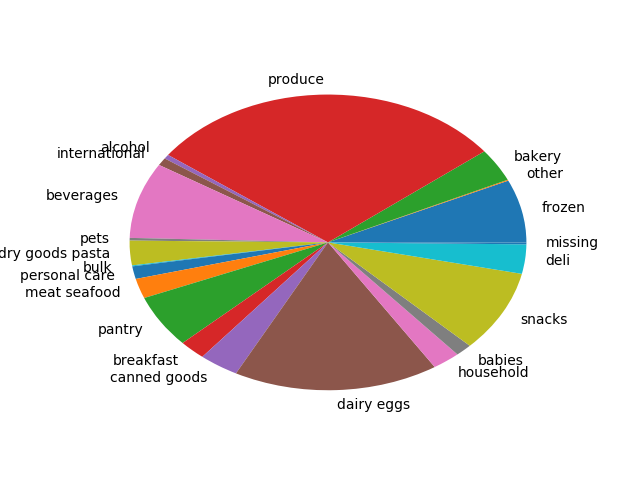

Text(0,0.5,'')

In [105]:
fig, ax = plt.subplots()

dept_sales = order_details.groupby('department_id').product_id.size()
ax = dept_sales.plot.pie(y='department_id', legend=False, labels=db['departments'].department)
ax.set_ylabel('')

<IPython.core.display.Javascript object>


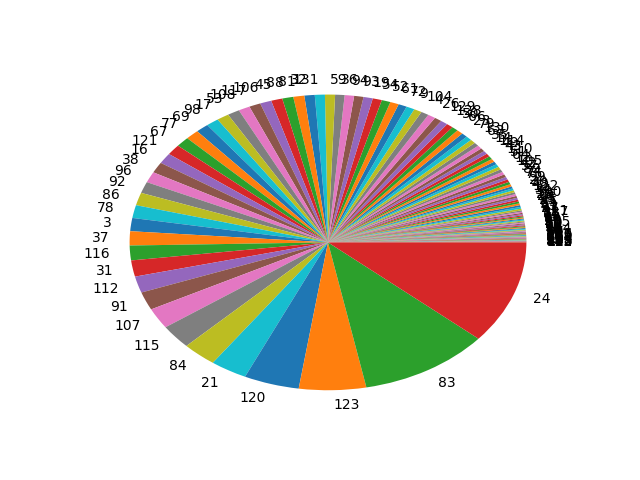

24 = fresh fruits
83 = fresh vegetables
123 = packaged vegetables fruits
120 = yogurt
21 = packaged cheese
84 = milk
115 = water seltzer sparkling water
107 = chips pretzels
91 = soy lactosefree
112 = bread
31 = refrigerated
116 = frozen produce


In [106]:
fig, ax = plt.subplots()

aisle_sales = order_details.groupby('aisle_id').product_id.size().sort_values()
ax = aisle_sales.plot.pie(y='aisle_id', legend=False)
ax.set_ylabel('')

for i in range(12):
    which = aisle_sales.index[-1-i]
    print('{} = {}'.format(which, db['aisles'].aisle.loc[which]))

<IPython.core.display.Javascript object>


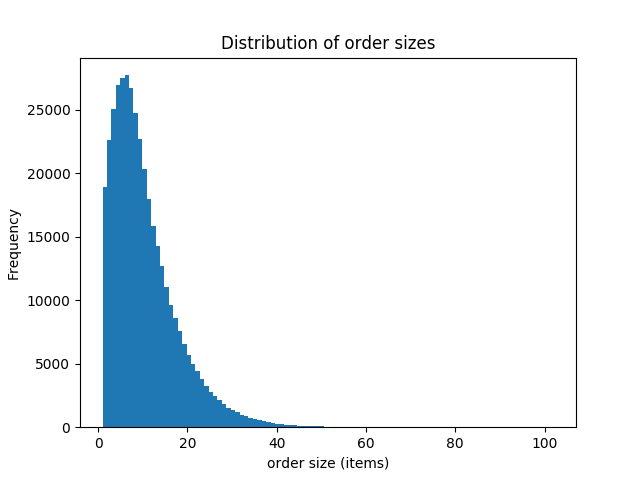

<module 'matplotlib.pyplot' from '/home/sam/.envs/instacart/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [107]:
ax = ops.groupby('order_id').size().plot.hist(bins=102)
ax.set_xlabel('order size (items)')
ax.set_title('Distribution of order sizes')
plt

<IPython.core.display.Javascript object>


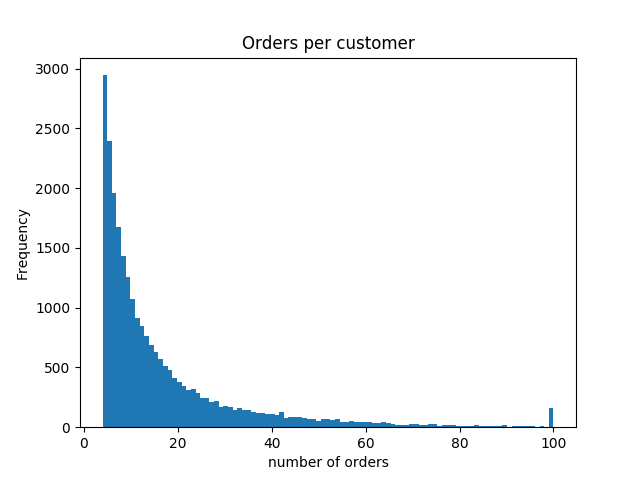

Text(0.5,1,'Orders per customer')

In [109]:
ax = orders.groupby('user_id').size().plot.hist(bins=97)  # tail accumulates at 100
ax.set_xlabel('number of orders')
ax.set_title('Orders per customer')

# Pareto distribution of order products

In [67]:
sum(order_details.product_id.value_counts()[:10]) / len(ops) 
# top 10 (of 50k) products: % of order items

0.07206760406015819

In [68]:
sum(order_details.product_id.value_counts()[:100]) / len(ops) 
# top 100 (of 50k) products: % of order items

0.2313904318989711

In [69]:
sum(order_details.product_id.value_counts()[:1000]) / len(ops) 
# top 1000 (of 50k) products: % of order items

0.5430262797072625

In [70]:
sum(order_details.product_id.value_counts()[:10000]) / len(ops) 
# top 20% (of 50k) products: % of order items

0.9142364470251706

# what percent of orders for a product are reorders?

In [160]:
tmp = pd.DataFrame({'reorder_pct': ops.groupby('product_id').reordered.mean(),
                    'num_orders': order_details.groupby('product_id').size()})

In [144]:
order_details = pd.merge(order_details, tmp, left_on='product_id', right_index=True)

<IPython.core.display.Javascript object>


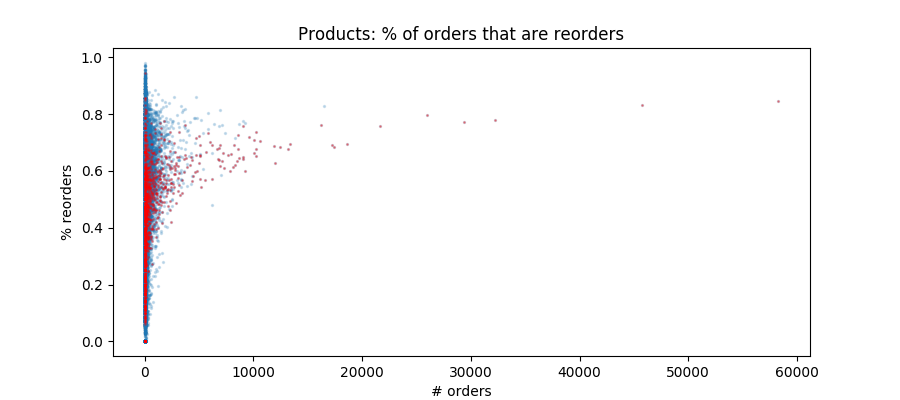

department    produce
Name: 4, dtype: object


In [145]:
# plot percentage reorders by department
fig, ax = plt.subplots()

print(db['departments'].loc[dept_id])

fig.set_size_inches(9,4)
ax.scatter(order_details.groupby('product_id').size(), 
           order_details.groupby('product_id').reorder_pct.mean(),
           s=2,
           alpha=.2,)

ax.scatter(order_details[order_details.department_id == 4].groupby('product_id').size(), 
           order_details[order_details.department_id == 4].groupby('product_id').reorder_pct.mean(),
           s=1,
           color='red',
           alpha=.3,)

ax.set_xlabel('# orders')
ax.set_ylabel('% reorders')
ax.set_title('Products: % of orders that are reorders')
plt.show()

# what is the outlier below mass of data points? x ~= 6300

In [161]:
products = pd.merge(products, tmp, left_index=True, right_index=True)

In [169]:
products[products.num_orders < 6500].sort_values('num_orders', ascending=False)[:10]

,product_name,aisle_id,department_id,reorder_pct,num_orders
product_id,,,,,
24838,Unsweetened Almondmilk,91,16,0.764101,6418
25890,Boneless Skinless Chicken Breasts,49,12,0.662765,6236
31506,Extra Virgin Olive Oil,19,13,0.480738,6230
46667,Organic Ginger Root,83,4,0.570601,6218
22825,Organic D'Anjou Pears,24,4,0.690595,6199
39928,Organic Kiwi,24,4,0.703342,6044
35221,Lime Sparkling Water,115,7,0.748578,5803
12341,Hass Avocados,32,4,0.734990,5796
5785,Organic Reduced Fat 2% Milk,84,16,0.805262,5777


In [151]:
products[ils.product_name.str.lower().str.contains('olive oil')][:10]

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,reorder_pct,num_orders
23,15,21195,2,1,54901,51,3,11,2.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632
508,449,21195,1,0,177340,7,3,17,30.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632
2163,1880,21195,14,1,20773,6,1,16,15.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632
3504,3004,21195,1,1,199714,6,1,9,30.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632
3791,3192,21195,7,1,144004,23,5,11,8.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632
4284,3603,21195,18,0,38453,2,0,16,6.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632
4563,3876,21195,15,1,95471,62,4,19,4.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632
6825,5751,21195,1,1,36069,28,2,12,9.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632
8975,7668,21195,2,1,109899,30,4,7,9.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632
12721,10853,21195,8,0,73826,25,0,18,7.0,Organic Extra Virgin Olive Oil,19,13,0.521446,1632


In [ ]:
user_mean_order_size = {}
user_std = {}
order_sizes = ops.groupby('order_id').size()

# get number of orders by user vs. average size of those orders
for i in tqdm(range(len(user_orders))):
    row = user_orders.iloc[i]   # row is list of orders a user has made
    user = user_orders.index[i]
    order_sizes_for_user = []
    for order in row:
        # print(order)
        try:
            order_sizes_for_user.append(order_sizes[order])
        except KeyError:
            continue
    user_mean_order_size[user] = pd.np.mean(order_sizes_for_user)
    user_std[user] = pd.np.std(order_sizes_for_user)

In [ ]:
user_orders[2]   # user no.2 has made these 15 orders

In [ ]:
plt.figure(figsize=(12,8))
ax = plt.scatter(x=users.num_orders, y=users.mean_order_size, s=3, alpha=.1)
ax.set_label('users')

In [ ]:
ax = orders.groupby('order_dow').size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week')

In [ ]:
ax = orders.groupby(['order_dow', 'order_hour_of_day']).size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week')
ax.set_xticks([24 * i for i in range(8)])
ax.set_xticklabels(range(8))

In [ ]:

ax = (orders[orders.order_dow == 0].groupby('order_hour_of_day').size()).plot(label='sat?')
ax = (orders[orders.order_dow == 1].groupby('order_hour_of_day').size()).plot(label='sun?')
ax.set_ylabel('Number of orders')
ax.set_xlabel('hour')

ax = (orders[orders.order_dow.isin([2,3,4,5,6])].groupby('order_hour_of_day').size()/5).plot(label='week')
ax.set_ybound(0)
ax.legend()

### Interesting features of time distribution: 

- weekday lunch trough
- first two days must be Sat/Sun? 5 vs. 2

# product time groups:

Do products vary significantly in terms of:
- order time
- cart add order

In [ ]:
ops.columns, order_details.columns

In [ ]:
order_details = pd.merge(ops, order_details, left_on='product_id', right_index=True)

In [ ]:
order_details.columns, orders.columns

In [ ]:
order_details = pd.merge(order_details, orders, on='order_id')

In [ ]:
order_details.columns

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in range(1, 11):
    series = order_details[order_details.department_id == i].groupby('days_since_prior_order').size()
    (series/series.max()).plot(label=db['departments'].department.loc[i])

ax.legend()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in range(1, 11):
    series = order_details[order_details.department_id == i].groupby('order_hour_of_day').size()
    (series/series.max()).plot(label=db['departments'].department.loc[i])

ax.legend()

In [ ]:
order_details.groupby('aisle_id')['order_hour_of_day'].mean().sort_values()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in [125, 46, 32, 94, 11, 119, 40, 76, 103, 37]:
    series = order_details[order_details.aisle_id == i].groupby('order_hour_of_day').size()
    (series/series.max()).plot(label=db['aisles'].aisle.loc[i])

ax.legend()
# early vs. late product